# Shop Segmentation

In [68]:
import numpy
import pandas as pd
from datetime import datetime
import dateutil
#import fbprophet as fb

### Read and Clean

In [4]:
#Read data

sales = pd.read_csv('historic_sales_data.csv')
items = pd.read_csv('items.csv')

In [5]:
#Join items to sales

sales = pd.merge(sales, items, on='item_id', how='left')

In [15]:
sales

,day,month,year,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_key,date,date_month
0,22,11,2018,52,1003734,1300,1,46,20181122,2018-11-22,2018-11-01
1,24,11,2018,52,1003734,1300,1,46,20181124,2018-11-24,2018-11-01
2,28,11,2018,52,1003734,1300,1,46,20181128,2018-11-28,2018-11-01
3,1,11,2018,52,1003743,400,1,42,20181101,2018-11-01,2018-11-01
4,20,11,2018,52,1003743,400,1,42,20181120,2018-11-20,2018-11-01
...,...,...,...,...,...,...,...,...,...,...,...
2664547,24,10,2018,118,1021620,200,3,80,20181024,2018-10-24,2018-10-01
2664548,31,10,2018,118,1021623,550,1,76,20181031,2018-10-31,2018-10-01
2664549,24,10,2018,118,1021624,500,1,74,20181024,2018-10-24,2018-10-01
2664550,25,10,2018,118,1021624,500,1,74,20181025,2018-10-25,2018-10-01


In [7]:
#dates
sales['date_key'] = sales['year'].astype(str) + sales['month'].apply(lambda x: f'{x:02d}') + sales['day'].apply(lambda x: f'{x:02d}')
sales['date'] = pd.to_datetime(sales['date_key'], format='%Y%m%d')

sales['date_month'] = sales['date'].dt.to_period('M').dt.to_timestamp()

#fix negative item counts
sales['item_cnt_day'] = abs(sales['item_cnt_day'])

### Feature Engineering

We will aim to engineer features around the following themes:

* RFM - recency, frequency, monetary/volume
* Average item price
* Product and product category variety
* Price sensitivity - discounts vs premiums
* Sales trend in past 12 months

In [29]:
#Calculate features for past 12 months (segmentation is more relevant)

sales_12m = sales[sales['date_month'] >= pd.to_datetime('2019-06-01')]

# Price Sensitivity
sales_12m['median_price'] = sales_12m.groupby(['item_id', 'date_month'])['item_price'].transform('median')

price_premium = sales_12m['item_price'] > sales_12m['median_price'] * 1.02
price_normal = (sales_12m['item_price'] <= sales_12m['median_price'] * 1.02) & (sales_12m['item_price'] >= sales_12m['median_price'] * 0.98)
price_discount = sales_12m['item_price'] < sales_12m['median_price'] * 0.98

sales_12m['pricing'] = ''

sales_12m.loc[price_premium, 'pricing'] = 'premium'
sales_12m.loc[price_normal, 'pricing'] = 'normal'
sales_12m.loc[price_discount, 'pricing'] = 'discount'

# Item categories simple price segments
item_prices = sales.groupby(['item_category_id', 'item_id']).agg(avg_price=('item_price', 'mean')).reset_index()

avg_cat_prices = item_prices.groupby('item_category_id')['avg_price'].mean().reset_index(name='avg_cat_price')

avg_cat_prices['category_price_class'] = pd.cut(
    avg_cat_prices['avg_cat_price'],
    bins=[-float('inf'), 1000, 4000, float('inf')],
    labels=['normal', 'high', 'v.high']
)

avg_cat_prices = avg_cat_prices.reset_index(drop=True)

sales_12m = pd.merge(sales_12m, avg_cat_prices, on='item_category_id')


# Calculate monthly aggregate metrics
sales_12m['revenue'] = sales_12m['item_cnt_day'] * sales_12m['item_price']

grouped_sales = sales_12m.groupby(['shop_id', 'date_month'])

shop_month_metrics = grouped_sales.agg(
    max_date=('date', 'max'),
    days_since_active=('date', lambda x: (pd.to_datetime('2020-05-31') - x.max()).days),
    active_days=('date', 'nunique'),
    volume_12m=('item_cnt_day', 'sum'),
    revenue_12m=('revenue', 'sum'),
    avg_item_price=('item_price', 'mean'),
    discount_volume=('item_cnt_day', lambda x: x[sales_12m['pricing'] == 'discount'].sum() / x.sum()),
    premium_volume=('item_cnt_day', lambda x: x[sales_12m['pricing'] == 'premium'].sum() / x.sum()),
    unique_items=('item_id', 'nunique'),
    unique_cat=('item_category_id', 'nunique'),
    unique_items_vhigh=('item_id', lambda x: x[sales_12m['category_price_class'] == 'v.high'].nunique() - 1),
    unique_items_high=('item_id', lambda x: x[sales_12m['category_price_class'] == 'high'].nunique() - 1),
    unique_items_normal=('item_id', lambda x: x[sales_12m['category_price_class'] == 'normal'].nunique() - 1)
).reset_index()


# Calculate aggregated metrics per shop
shop_summary = shop_month_metrics.groupby('shop_id').agg(
    days_since_active=('days_since_active', 'min'),
    m_active_months=('date_month', 'count'),
    m_active_days=('active_days', 'mean'),
    m_volume=('volume_12m', 'mean'),
    m_revenue=('revenue_12m', 'mean'),
    m_avg_item_price=('avg_item_price', 'mean'),
    m_discount_volume=('discount_volume', 'mean'),
    m_premium_volume=('premium_volume', 'mean'),
    m_unique_items=('unique_items', 'mean'),
    m_unique_cat=('unique_cat', 'mean'),
    m_unique_items_vhigh=('unique_items_vhigh', 'mean'),
    m_unique_items_high=('unique_items_high', 'mean'),
    m_unique_items_normal=('unique_items_normal', 'mean')
).reset_index()

C:\Users\vishalin1\AppData\Local\Temp\ipykernel_22364\364900151.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_12m['median_price'] = sales_12m.groupby(['item_id', 'date_month'])['item_price'].transform('median')
C:\Users\vishalin1\AppData\Local\Temp\ipykernel_22364\364900151.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_12m['pricing'] = ''


In [45]:
#Sales Volume Trend Per Shop

from sklearn.linear_model import LinearRegression

#List of shops
shops = sales.groupby('shop_id').size().reset_index(name='count')

# Create smooth_dates DataFrame
smooth_dates = pd.DataFrame({'date_month': pd.date_range(start='2018-01-01', end='2020-05-01', freq='MS')})

# Fitting a linear model for each shop sale trend
shop_trend = pd.DataFrame(columns=['shop_id', 'trend'])

for sid in shops['shop_id']:
    lm_df = (
        sales[(sales['date_month'] >= '2019-06-01') & (sales['shop_id'] == sid)]
        .groupby('date_month')['item_cnt_day']
        .sum()
        .reset_index(name='sales_volume')
    )

    if lm_df['sales_volume'].count() < 2:
        coef = 0
    else:
        lm_df['sales_volume'] = lm_df['sales_volume'] / lm_df['sales_volume'].mean()

        lm_df['sales_volume'] = lm_df['sales_volume'].fillna(0)
        
        # Full join with smooth_dates
        lm_df = pd.merge(smooth_dates, lm_df, how='outer', on='date_month').sort_values('date_month')

        # Add a variable 'var' for regression
        lm_df['var'] = range(1, len(lm_df) + 1)

        lm_df = lm_df.dropna()
        
        # Fit linear model
        linmod = LinearRegression().fit(lm_df[['var']], lm_df['sales_volume'])
        coef = linmod.coef_[0]

    # Append to shop_trend DataFrame
    shop_trend = pd.concat([shop_trend, pd.DataFrame({'shop_id': [sid], 'trend': [coef]})])

shop_trend = shop_trend.reset_index(drop=True)

In [56]:
#Assemble all features for segmentation

shop_summary = pd.merge(shop_summary, shop_trend, on='shop_id', how='left')


#scale vars
from sklearn.preprocessing import scale
shops_clust = shop_summary.apply(scale)


### PCA: Dimensionality Reduction

Principal component analysis will be used to reduce redundancy in features for modelling. This is especially important for clustering algorithms as we do not want to overrepresent any variable/measurement as this can over signify the importance of these variables in distance separation.

In [64]:
import sklearn.preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

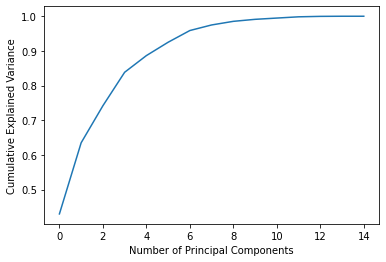

In [71]:
# PCA
pca = PCA()
pca_result = pca.fit_transform(shops_clust)

# Plot cumulative explained variance
plt.plot(numpy.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Visualize eigenvalues
eigenvalues = pca.explained_variance_
cumulative_eigenvalues = numpy.cumsum(eigenvalues) / sum(eigenvalues)


In [72]:
#First 6 components explain ~95% of variance

#choose 6 components for clustering
num_components = 6

shops_12m_pcaclust = pd.DataFrame(pca_result[:, :num_components], columns=[f'PC{i}' for i in range(1, num_components + 1)])

### Gaussian Mixture Model

The first chosen model is a gaussian mixture model. This algorithm works well with clusters of different shapes, sizes, and complexity. We can also observe probabilities of cluster membership, which may be useful when a particular observation straddles more than one cluster (a hybrid).

In [74]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [82]:
# We will try building 10 models each with an increasing number of components/clusters from 1 to 10
n_components_range = range(2, 10)

# Fit GMMs with different numbers of components
bic_scores = []
silhouette_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=12)
    gmm.fit(shops_12m_pcaclust)
    bic_scores.append(gmm.bic(shops_12m_pcaclust))
    
    labels = gmm.predict(shops_12m_pcaclust)
    silhouette_avg = silhouette_score(shops_12m_pcaclust, labels)
    silhouette_scores.append(silhouette_avg)



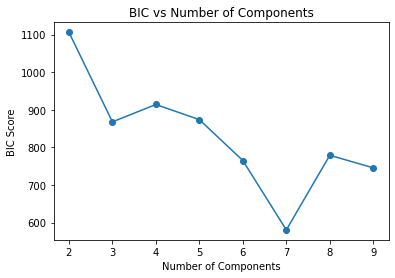

In [83]:
# Plot Bayesian Inference Criteria vs number of components
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

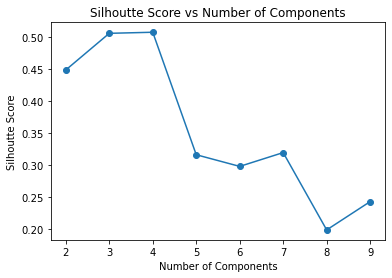

In [86]:
#Plot Silhoutte Score vs number of components
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhoutte Score vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Silhoutte Score')
plt.show()

In [91]:
# 7 components appears to be the sweet spot for the BIC, this means that 7 clusters is a reasonable choice for balancing
# complexity and variance
# The silhoutte score decreases with an increasing number of clusters (generally expected as more complexity results in more 
# overlap), however there is a similar inflection point for 7 clusters, indicating some stability for this number.

gmm_final = GaussianMixture(n_components=7, random_state=12)

gmm_final.fit(shops_12m_pcaclust)


GaussianMixture(n_components=7, random_state=12)

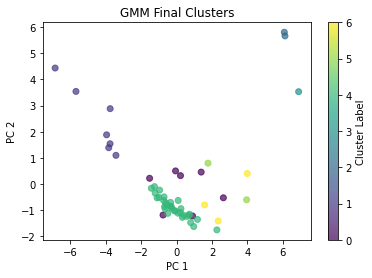

In [133]:
# Visualize clusters across the top 2 principal components
labels = gmm_final.predict(shops_12m_pcaclust)

pca = PCA(n_components=2)
projection = pca.fit_transform(shops_12m_pcaclust)

plt.scatter(projection[:, 0], projection[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('GMM Final Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [96]:
# Reasonably good separation across just the first 2 PCs

# Cluster aggregate statistics

#shop_summary['cluster'] = labels

cluster_summary = shop_summary.groupby('cluster').agg(['mean', 'median', 'min', 'max', 'count'])
cluster_summary = cluster_summary.reset_index()

In [112]:
# View cluster summary statistics
print(cluster_summary)

  cluster    shop_id                       days_since_active                   \
                mean median min  max count              mean median  min  max   
0       0  40.857143   34.0   4   86     7         57.285714   37.0    0  134   
1       1  75.428571   62.0  50  114     7          5.428571    0.0    0   38   
2       2  29.000000   29.0  18   40     2        138.500000  138.5   39  238   
3       3  26.000000   26.0  26   26     1        296.000000  296.0  296  296   
4       4  65.875000   72.0   6  118    32          0.093750    0.0    0    3   
5       5  95.000000   95.0  80  110     2         61.500000   61.5    0  123   
6       6  48.000000   22.0  20  102     3         31.000000    0.0    0   93   

   ... m_unique_items_normal                                               \
   ...                  mean       median          min          max count   
0  ...            657.855159   640.125000   352.111111  1121.583333     7   
1  ...           1804.514069  1583.2500

### Clusters and high level attributes

(More detailed cluster analysis in presentation of results)


| Cluster | Count | Descr                                                                 |
| :------ | :---- | :-------------------------------------------------------------------- |
| 0 | 7 | Not active in last month, however usually active for most days in a month. Medium sales vol, high avg price. Medium discounting/promotions. Medium variety of products. Sales trending slightly up.
| 1 | 7 | Continuously, highly active. Highest sales volume, mid-high avg price. Medium discounting/promotions. Very high variety of products. Sales trending slightly down.
| 2 | 2 | Not active for long period ~1-6 months, spikes of activity per year. High sales volume, very high avg price. High discounting/promotions. Low variety of products. Sales trending down.
| 3 | 1 | Single shop, not active in last ~300 days. Low sales volume, very low avg price. Almost entirely discounted (could this be wholesaler/distributor? or low income targetting). Low variety of products. 
| 4 | 32 | Continuously, highly active. Medium sales vol, high avg price. Medium discounting/promotions. High variety of products. Sales trending slightly down. 
| 5 | 2 | Not active in last 2 months, however usually active for most days/months. Medium sales volume, medium avg price. Low discounting/promotions. Low variety of products. Sales trending up.
| 6 | 3 | Continuously, highly active, misses some months. Low sales volume, low avg price. Almost entirely discounted (potential wholesaler/distributor or low income targetting). Low variety of products. Sales trending down.

### DBSCAN (Alternative Approach)

In [114]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

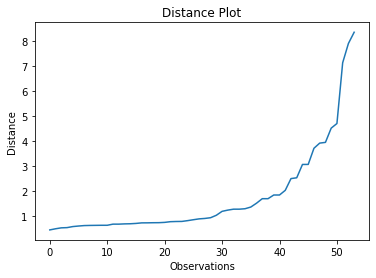

In [121]:
# Exploring neighbour distances to inform choice of epsilon

# Choose min sample parameter in dbscan alg as '2' (min required points to consider region dense) 
min_samples_value = 2

neighbors = NearestNeighbors(n_neighbors=min_samples_value)
distances, _ = neighbors.fit(shops_12m_pcaclust).kneighbors()

# Sort distances and plot
sorted_distances = numpy.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.title('Distance Plot')
plt.show()

In [128]:
# Distance of 2 seems to be where there is a steep pick up in distance - we will choose this for epsilon

eps_value = 2
dbs_mod = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels_db = dbs_mod.fit_predict(shops_12m_pcaclust)

# Evaluate the model
silhouette_avg = silhouette_score(shops_12m_pcaclust, labels_db)
print(f"Silhouette Score: {silhouette_avg}")



Silhouette Score: 0.4219103542997588


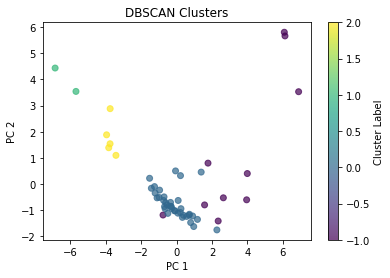

In [129]:
# Visualize clusters across the top 2 principal components
projection = pca.fit_transform(shops_12m_pcaclust)

plt.scatter(projection[:, 0], projection[:, 1], c=labels_db, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster Label')
plt.show()

DBSCAN has produced statistically better results from its clustering than GMM:

* A Silhoutte Score of ~42%
* Cleaner cluster boundaries across the first 2 PCs

However as with all segmentation approaches, the importance is the explainability of clusters in the real world and within the context of the business domain. In this case we have a higher silhouette score, but fewer clusters. It is up to business users and the data scientist to determine whether the gaps in the clusters are meaningful or not, and whether more separation (complexity) is necessary.

In [136]:
#Write results to csv
segmentation_results = pd.DataFrame({
    'shop_id': shop_summary['shop_id'],
    'gmm_clust': labels, 
    'dbscan_clust': labels_db 
})

segmentation_results.to_csv('Output/segmentation.csv', index=False)